Installing required packages and dependencies

In [2]:

!pip install gym
!pip install stable-baselines[mpi]
!pip install stable-baselines3[extra]

#!pip install tensorflow
#!pip install keras
#!pip install keras-rl2
#!pip install pygame
#!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 19.2 MB/s 
     |████████████████████████████████| 2.5 MB 65.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185288 sha256=61e43963f8530e880459c6d77e31c4ed1a39c0c4e50a0fbc80f7d74c659d2a46
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 28.3 MB/s 
     |████████████████████████████████| 1.5 MB 67.0 MB/s 
     |████████████████████████████████| 1.6 MB 45

In [3]:
import pandas as pd
import datetime
from google.colab import drive
drive.mount('/content/drive')

current_folder = 'drive/My Drive/DAI-Labor/Thesis/'
input_folder = 'drive/My Drive/DAI-Labor/Thesis/data/environment_table_0/'
output_folder = 'drive/My Drive/DAI-Labor/Thesis/data/environment_optimized_output_0/'

VPP_data = pd.read_csv(input_folder + 'VPP_table_complete.csv')
VPP_data['time'] = pd.to_datetime(VPP_data['time'])
time_serie = VPP_data['time'].values
simulation_len = len(time_serie)
VPP_data = VPP_data.iloc[:,2:]

#VPP_data.info()
VPP_data.head()

Mounted at /content/drive


,ev_power,household_power,renewable_power,EUR/kWh,House&RW_load,total_load,total_cost,Available_energy_sources,1,2,...,69,70,71,72,73,74,75,76,77,78
0,0.0,0.403179,0.238,0.04084,0.165179,0.165179,0.001686,[],0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.405153,0.238,0.04084,0.167153,0.167153,0.001707,[],0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.537645,0.238,0.04084,0.299645,0.299645,0.003059,[],0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.779943,0.238,0.04084,0.541943,0.541943,0.005533,[],0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.732574,0.223,0.04115,0.509574,0.509574,0.005242,[],0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# import gym
# #import pygame

In [5]:
from gym import Env
from gym.spaces import Discrete, Box, Dict, MultiDiscrete
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
#from IPython import display
#export DISPLAY=localhost:0.0
import stable_baselines3 as sb3
sb3.get_system_info()

OS: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic #1 SMP Sun Apr 24 10:03:06 PDT 2022
Python: 3.7.13
Stable-Baselines3: 1.5.0
PyTorch: 1.11.0+cu113
GPU Enabled: True
Numpy: 1.21.6
Gym: 0.21.0



({'GPU Enabled': 'True',
  'Gym': '0.21.0',
  'Numpy': '1.21.6',
  'OS': 'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic #1 SMP Sun Apr 24 10:03:06 PDT 2022',
  'PyTorch': '1.11.0+cu113',
  'Python': '3.7.13',
  'Stable-Baselines3': '1.5.0'},
 'OS: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic #1 SMP Sun Apr 24 10:03:06 PDT 2022\nPython: 3.7.13\nStable-Baselines3: 1.5.0\nPyTorch: 1.11.0+cu113\nGPU Enabled: True\nNumpy: 1.21.6\nGym: 0.21.0\n')

In [6]:
#Loading vehicle energies table UNOPTIMIZED
LIST_Init_space_Available_energy_sources = VPP_data["Available_energy_sources"].values
Unoptimized_Simulation_energy_State_space = np.float32(VPP_data.iloc[:,8:].values)
#Loading total number of vehicles in the simulation
EV_simulation_n =len(Unoptimized_Simulation_energy_State_space[0])
#Creating copy to be modified
VPP_energies = Unoptimized_Simulation_energy_State_space
#Loading other parameters table UNOPTIMIZED
ev_power_serie = VPP_data["ev_power"].values
houseRWload_serie = (VPP_data["House&RW_load"].values) #Household load with Renewables without considering EV connected
prices_serie = VPP_data["EUR/kWh"].values
total_cost_serie = np.zeros(simulation_len)

#Initializing Available energy values for the first step
Init_space_Available_energy_sources = Unoptimized_Simulation_energy_State_space[0]
#Initializing other parameters for the first step
Init_space_ev_power = np.zeros(1,dtype=np.float32)
Init_space_total_load = np.zeros(1,dtype=np.float32)
Init_space_total_cost = np.zeros(1,dtype=np.float32)

Init_space_ev_power[0] = VPP_data["ev_power"].values[0]
Init_space_total_load[0] = VPP_data["total_load"].values[0]
Init_space_total_cost[0] = VPP_data["total_cost"].values[0]

print(len(Unoptimized_Simulation_energy_State_space))
print(EV_simulation_n)
print(Init_space_ev_power)
print(Init_space_total_load)
print(Init_space_total_cost)
print(Init_space_Available_energy_sources)

2881
78
[0.]
[0.165179]
[0.00168648]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [7]:
Init_space = {
    'ev_power': Init_space_ev_power, #EV load range in kW, depends on the infrastructure of the simulation
    'total_load': Init_space_total_load, #Total load range in kW, depends on the household and EV infrastructure of the simulation
    'total_cost': Init_space_total_cost, #Total cost (EUR) per timestep (15 min)
    'Available_energy_sources': Init_space_Available_energy_sources #all EV energy state
}

In [8]:
class VPPEnv(Env):
  

  def __init__(self):
    #Actions we can take
    #self.action_space = Discrete(7)
   
    self.action_space = MultiDiscrete( 7 * np.ones(EV_simulation_n))

    # Define constants for clearer code
    
    self.IDLE = 0
    self.CHARGE_3_7 = 1
    self.DISCHARGE_3_7 = 2

    self.CHARGE_7_4 = 3
    self.DISCHARGE_7_4 = 4

    self.CHARGE_11 = 5
    self.DISCHARGE_11 = 6

    #Charging station Power array
    #self.observation_space = Box(low = np.array([0]), high = np.array([1000])) #Example

    #TO DO: NORMALIZE ACTION SPACE (not if you use algorithm TD3 and DDPG)
    spaces = {
      'ev_power': Box(low=0, high=18.5, shape=(1,), dtype=np.float32), #EV load range in kW, depends on the infrastructure of the simulation
      # #'ev_power': gym.spaces.Box(low=0, high=18.5, shape=(simulation_len,)),
      'total_load': Box(low=-30, high=30, shape=(1,), dtype=np.float32), #Total load range in kW, depends on the household and EV infrastructure of the simulation
      'total_cost': Box(low=-0.30, high=0.60, shape=(1,), dtype=np.float32),#Total cost (EUR) per timestep (15 min)
      'Available_energy_sources': Box(low=0.0, high=100, shape=(EV_simulation_n,), dtype=np.float32)
      }
    #gym.spaces.Dict()
    dict_space = Dict(spaces)
    self.observation_space = dict_space

    #Set starting cond.
    self.state = Init_space
    #Set VPP session length
    self.vpp_length = simulation_len

    #Set parameter series to be updated along the simuulation
    self.VPP_energies = Unoptimized_Simulation_energy_State_space
    
    self.total_ev_power_serie = ev_power_serie
    self.total_load_serie = houseRWload_serie
    self.prices_serie = prices_serie #EUR/kWh
    self.total_cost_serie = total_cost_serie



  def step(self, action):
    #evaluate step
    step = simulation_len - self.vpp_length

    #Apply action section  
    Energy_sources_t = self.VPP_energies[step]
    if step > 0:
      Energy_sources_t_1 = self.VPP_energies[step-1]
      #OR
      #Energy_sources_t_1 = self.state['Available_energy_sources']
    
    #Reward Initialization
    reward = 0

    #Variables inititalization for calculations
    total_ev_power_t = 0
    total_load_t = self.total_load_serie[step]

    #TO DO evaluate total_ev_power_t
    #__INIT__ ACTION VECTOR LOOP
    for j in range(EV_simulation_n):
      #1. CHECK CURRENT STEP (case: current step in range)
      if Energy_sources_t[j] > 0 and Energy_sources_t[j] <= 100:

        if step == 0: #2.FIRST STEP CASE
          #4.1 ACTIONS:
          if action[j] == self.CHARGE_3_7: #(already considered charged)
            Energy_sources_t[j] = Energy_sources_t[j] #STORING ENERGY
            total_ev_power_t += 3.7
            if Energy_sources_t[j] > 100: #Reached max capacity (kWh)
              total_ev_power_t -= 3.7
              Energy_sources_t[j] = 100
          elif action[j] == self.CHARGE_7_4: #(already considered charged)
            Energy_sources_t[j] = Energy_sources_t[j] + ((7.4 * 0.25) - (3.7 * 0.25))#STORING ENERGY
            total_ev_power_t += 7.4
            if Energy_sources_t[j] > 100: #Reached max capacity (kWh)
              total_ev_power_t -= 7.4
              Energy_sources_t[j] = 100
          elif action[j] == self.CHARGE_11: #(already considered charged)
            Energy_sources_t[j] = Energy_sources_t[j] + ((11 * 0.25) - (3.7 * 0.25))#STORING ENERGY
            total_ev_power_t += 11
            if Energy_sources_t[j] > 100: #Reached max capacity (kWh)
              total_ev_power_t -= 11
              Energy_sources_t[j] = 100
          elif action[j] == self.IDLE: #(subtracting energy already considered charged)
            Energy_sources_t[j] = Energy_sources_t[j] - (3.7 * 0.25) #keep energy constant
            if Energy_sources_t[j] < 0: #Reached min capacity (kWh)
              Energy_sources_t[j] = 0.01
          elif action[j] == self.DISCHARGE_3_7: # (subtracting energy already considered charged AND pushed)
            Energy_sources_t[j] = Energy_sources_t[j] - 2*(3.7 * 0.25) #PUSHING ENERGY
            total_ev_power_t -= 3.7
            if Energy_sources_t[j] < 0: #Reached min capacity (kWh)
              total_ev_power_t += 3.7
              Energy_sources_t[j] = 0.01
          elif action[j] == self.DISCHARGE_7_4: # (subtracting energy already considered charged AND pushed)
            Energy_sources_t[j] = Energy_sources_t[j] - ((3.7 * 0.25) + (7.4 * 0.25)) #PUSHING ENERGY
            total_ev_power_t -= 7.4
            if Energy_sources_t[j] < 0: #Reached min capacity (kWh)
              total_ev_power_t += 7.4
              Energy_sources_t[j] = 0.01
          elif action[j] == self.DISCHARGE_11: # (subtracting energy already considered charged AND pushed)
            Energy_sources_t[j] = Energy_sources_t[j] - ((3.7 * 0.25) + (11 * 0.25)) #PUSHING ENERGY
            total_ev_power_t -= 11
            if Energy_sources_t[j] < 0: #Reached min capacity (kWh)
              total_ev_power_t += 11
              Energy_sources_t[j] = 0.01
          else:
            raise ValueError("Received invalid action={} which is not part of the action space".format(action))

        else:#2.OTHER STEPS CASES > 0
          
          #3.Check previous step range (CASE 3.1: CAR ALREADY CONNECTED)
          if Energy_sources_t_1[j] > 0 and Energy_sources_t_1[j] <= 100:
            
            #4.2 ACTIONS:
            if action[j] == self.CHARGE_3_7:
              Energy_sources_t[j] = Energy_sources_t_1[j] + (3.7 * 0.25) #3.7 kW * 15 min = kWh STORING ENERGY
              total_ev_power_t += 3.7
              if Energy_sources_t[j] > 100: #Reached max capacity (kWh)
                total_ev_power_t -= 3.7
                Energy_sources_t[j] = 100
            elif action[j] == self.CHARGE_7_4:
              Energy_sources_t[j] = Energy_sources_t_1[j] + (7.4 * 0.25) #7.4 kW * 15 min = kWh STORING ENERGY
              total_ev_power_t += 7.4
              if Energy_sources_t[j] > 100: #Reached max capacity (kWh)
                total_ev_power_t -= 7.4
                Energy_sources_t[j] = 100
            elif action[j] == self.CHARGE_11:
              Energy_sources_t[j] = Energy_sources_t_1[j] + (11 * 0.25) #11 kW * 15 min = kWh STORING ENERGY
              total_ev_power_t += 11
              if Energy_sources_t[j] > 100: #Reached max capacity (kWh)
                total_ev_power_t -= 11
                Energy_sources_t[j] = 100
            elif action[j] == self.IDLE:
              Energy_sources_t[j] = Energy_sources_t_1[j] #keep energy constant
            elif action[j] == self.DISCHARGE_3_7:
              Energy_sources_t[j] = Energy_sources_t_1[j] - (3.7 * 0.25) #3.7 kW * 15 min = kWh PUSHING ENERGY
              total_ev_power_t -= 3.7
              if Energy_sources_t[j] < 0: #Reached min capacity (kWh)
                total_ev_power_t += 3.7
                Energy_sources_t[j] = 0.01
            elif action[j] == self.DISCHARGE_7_4:
              Energy_sources_t[j] = Energy_sources_t_1[j] - (7.4 * 0.25) #7.4 kW * 15 min = kWh PUSHING ENERGY
              total_ev_power_t -= 7.4
              if Energy_sources_t[j] < 0: #Reached min capacity (kWh)
                total_ev_power_t += 7.4
                Energy_sources_t[j] = 0.01
            elif action[j] == self.DISCHARGE_11:
              Energy_sources_t[j] = Energy_sources_t_1[j] - (11 * 0.25) #3.7 kW * 15 min = kWh PUSHING ENERGY
              total_ev_power_t -= 11
              if Energy_sources_t[j] < 0: #Reached min capacity (kWh)
                total_ev_power_t += 11
                Energy_sources_t[j] = 0.01
            else:
              raise ValueError("Received invalid action={} which is not part of the action space".format(action))
          
          #3.Check previous step (CASE 3.2: CAR JUST CONNECTED)
          elif Energy_sources_t_1[j] == 0: #When car just connects
            
            #4.3 ACTIONS:
            if action[j] == self.CHARGE_3_7: #(already considered charged)
              Energy_sources_t[j] = Energy_sources_t[j] #STORING ENERGY
              total_ev_power_t += 3.7
              if Energy_sources_t[j] > 100: #Reached max capacity (kWh)
                total_ev_power_t -= 3.7
                Energy_sources_t[j] = 100
            elif action[j] == self.CHARGE_7_4: #(already considered charged)
              Energy_sources_t[j] = Energy_sources_t[j] + ((7.4 * 0.25) - (3.7 * 0.25)) #7.4 kW * 15 min = kWh PUSHING ENERGY - the already considered pushed one
              total_ev_power_t += 7.4
              if Energy_sources_t[j] > 100: #Reached max capacity (kWh)
                total_ev_power_t -= 7.4
                Energy_sources_t[j] = 100
            elif action[j] == self.CHARGE_11: #(already considered charged)
              Energy_sources_t[j] = Energy_sources_t[j] + ((11 * 0.25) - (3.7 * 0.25)) #11 kW * 15 min = kWh PUSHING ENERGY - the already considered pushed one
              total_ev_power_t += 11
              if Energy_sources_t[j] > 100: #Reached max capacity (kWh)
                total_ev_power_t -= 11
                Energy_sources_t[j] = 100
            elif action[j] == self.IDLE: #(subtracting energy already considered charged)
              Energy_sources_t[j] = Energy_sources_t[j] - (3.7 * 0.25) #keep energy constant
              if Energy_sources_t[j] < 0: #Reached min capacity (kWh)
                Energy_sources_t[j] = 0.01
            elif action[j] == self.DISCHARGE_3_7: # (subtracting energy already considered charged AND pushed)
              Energy_sources_t[j] = Energy_sources_t[j] - 2*(3.7 * 0.25) #PUSHING ENERGY
              total_ev_power_t -= 3.7
              if Energy_sources_t[j] < 0: #Reached min capacity (kWh)
                total_ev_power_t += 3.7
                Energy_sources_t[j] = 0.01
            elif action[j] == self.DISCHARGE_7_4: # (subtracting energy already considered charged AND pushed)
              Energy_sources_t[j] = Energy_sources_t[j] - (3.7 * 0.25) - (7.4 * 0.25) #PUSHING ENERGY
              total_ev_power_t -= 7.4
              if Energy_sources_t[j] < 0: #Reached min capacity (kWh)
                total_ev_power_t += 7.4
                Energy_sources_t[j] = 0.01
            elif action[j] == self.DISCHARGE_11: # (subtracting energy already considered charged AND pushed)
              Energy_sources_t[j] = Energy_sources_t[j] - (3.7 * 0.25) - (11 * 0.25) #PUSHING ENERGY
              total_ev_power_t -= 11
              if Energy_sources_t[j] < 0: #Reached min capacity (kWh)
                total_ev_power_t += 11
                Energy_sources_t[j] = 0.01
            else:
              raise ValueError("Received invalid action={} which is not part of the action space".format(action))
          
          #3.Check previous step (CASE 3.3: error previous state)
          else:
            raise ValueError("Available_energy_sources table out of ranges: state={} which is not part of the state space".format(Energy_sources_t_1))
      
      #1. CHECK CURRENT STEP (case: current step out of range)
      elif Energy_sources_t[j] != 0:
          raise ValueError("Available_energy_sources table out of ranges: state={} which is not part of the state space".format(Energy_sources_t))
    
      
      #Calculating reward for energy level in car j at instant t
      #TO DO: EVALUATE REWARD AT LEAVING TIME
      if Energy_sources_t[j] != 0:
        
        if Energy_sources_t[j] > 0 and Energy_sources_t[j] <= 25:
          reward += -2
        elif Energy_sources_t[j] > 25 and Energy_sources_t[j] <= 40:
          reward += -1
        elif Energy_sources_t[j] > 40 and Energy_sources_t[j] <= 55:
          reward += 0
        elif Energy_sources_t[j] > 55 and Energy_sources_t[j] <= 65:
          reward += 1
        elif Energy_sources_t[j] > 65 and Energy_sources_t[j] <= 85:
          reward += 2
        elif Energy_sources_t[j] > 85 and Energy_sources_t[j] < 95:
          reward += 1
        elif Energy_sources_t[j] > 85 and Energy_sources_t[j] < 99:
          reward += 0
        elif Energy_sources_t[j] >= 99 and Energy_sources_t[j] <= 100:
          reward += -1
    
    #__END__ ACTION VECTOR LOOP

    #VPP Table evaluation
    total_load_t = total_load_t + total_ev_power_t
    cost_t  = total_load_t * self.prices_serie[step] / 4
    #TO DO Evaluating rewards for EV_power, total_load, and cost at instant t
    #EV power reward
    if total_ev_power_t <= -10 :
      reward += 10
    elif total_ev_power_t  > -10 and total_ev_power_t <= 0.1:
      reward += 20
    elif total_ev_power_t  > -0.1 and total_ev_power_t <= 0.05:
      reward += 30
    elif total_ev_power_t  > -0.05 and total_ev_power_t <= 1.5:
      reward += 10
    elif total_ev_power_t  > 1.5 and total_ev_power_t <= 2:
      reward += 5
    elif total_ev_power_t  > 2 and total_ev_power_t <= 3:
      reward += 0
    elif total_ev_power_t  > 3 and total_ev_power_t <= 5:
      reward -= 5
    elif total_ev_power_t  > 5 and total_ev_power_t <= 10:
      reward -= 10
    elif total_ev_power_t  > 10 and total_ev_power_t <= 13.5:
      reward -= 20
    elif total_ev_power_t  > 13.5 and total_ev_power_t <= 17:
      reward -= 30
    elif total_ev_power_t  > 17:
      reward -= 40

    #Total load reward

    if total_load_t <= -10 :
      reward += 10
    elif total_load_t  > -10 and total_load_t <= 0.1:
      reward += 20
    elif total_load_t  > -0.1 and total_load_t <= 0.05:
      reward += 30
    elif total_load_t  > -0.05 and total_load_t <= 1.5:
      reward += 10
    elif total_load_t  > 1.5 and total_load_t <= 2:
      reward += 5
    elif total_load_t  > 2 and total_load_t <= 3:
      reward += 0
    elif total_load_t  > 3 and total_load_t <= 5:
      reward -= 5
    elif total_load_t  > 5 and total_load_t <= 10:
      reward -= 10
    elif total_load_t  > 10 and total_load_t <= 13.5:
      reward -= 20
    elif total_load_t  > 13.5 and total_load_t <= 17:
      reward -= 30
    elif total_load_t  > 17 and total_load_t <= 20:
      reward -= 40
    elif total_load_t  > 20:
      reward -= 50

    #Cost reward
    if cost_t <= -0.1 :
      reward += 50
    elif cost_t  > -0.1 and cost_t <= -0.05:
      reward += 40
    elif cost_t  > -0.05 and cost_t <= -0.01:
      reward += 30
    elif cost_t  > -0.01 and cost_t <= -0.005:
      reward += 20
    elif cost_t  > -0.005 and cost_t <= 0.001:
      reward += 10
    elif cost_t  > -0.001 and cost_t <= 0.001:
      reward += 5
    elif cost_t  > 0.001 and cost_t <= 0.01:
      reward += 0
    elif cost_t  > 0.01 and cost_t <= 0.03:
      reward -= 5
    elif cost_t  > 0.03 and cost_t <= 0.05:
      reward -= 10
    elif cost_t  > 0.05 and cost_t <= 0.1:
      reward -= 20
    elif cost_t  > 0.1 and cost_t <= 0.15:
      reward -= 30
    elif cost_t  > 0.15 and cost_t <= 0.2:
      reward -= 40
    elif cost_t  > 0.2 and cost_t <= 0.25:
      reward -= 50
    elif cost_t  > 0.25 and cost_t <= 0.3:
      reward -= 60
    elif cost_t  > 0.3:
      reward -= 70
    
    

    #VPP Table UPDATE
    self.VPP_energies[step] = Energy_sources_t
    self.total_ev_power_serie[step] = total_ev_power_t
    self.total_load_serie[step] = total_load_t
    self.total_cost_serie[step] = cost_t

    #STATE UPDATE
    self.state['Available_energy_sources'] = Energy_sources_t
    ev_power_state = np.zeros(1,dtype=np.float32)
    ev_power_state[0] = total_ev_power_t
    self.state['ev_power'] = ev_power_state
    load_state = np.zeros(1,dtype=np.float32)
    load_state[0] = total_load_t
    self.state['total_load'] = load_state
    cost_state = np.zeros(1,dtype=np.float32)
    cost_state[0] = cost_t
    self.state['total_cost'] = cost_state

    #Reduce VPP session length by 1 step
    self.vpp_length -= 1
    #Check if VPP is done
    if self.vpp_length <= 0:
      done = True

      total_load_t = np.sum(self.total_load_serie)
      cost_t = np.sum(self.total_cost_serie)
      print("Total cost: € ", cost_t, ", Total energy consumed: KWh ", total_load_t), 

      #Final Total load reward

      if total_load_t <= -10 :
        reward += 10
      elif total_load_t  > -10 and total_load_t <= 0.1:
        reward += 20
      elif total_load_t  > -0.1 and total_load_t <= 0.05:
        reward += 30
      elif total_load_t  > -0.05 and total_load_t <= 1.5:
        reward += 10
      elif total_load_t  > 1.5 and total_load_t <= 2:
        reward += 5
      elif total_load_t  > 2 and total_load_t <= 3:
        reward += 0
      elif total_load_t  > 3 and total_load_t <= 5:
        reward -= 5
      elif total_load_t  > 5 and total_load_t <= 10:
        reward -= 10
      elif total_load_t  > 10 and total_load_t <= 13.5:
        reward -= 20
      elif total_load_t  > 13.5 and total_load_t <= 17:
        reward -= 30
      elif total_load_t  > 17 and total_load_t <= 20:
        reward -= 40
      elif total_load_t  > 20:
        reward -= 50

      #Final Cost reward
      if cost_t <= -50 :
        reward += 500
      elif cost_t  > -50 and cost_t <= -20:
        reward += 300
      elif cost_t  > -20 and cost_t <= -5:
        reward += 200
      elif cost_t  > -5 and cost_t <= 0:
        reward += 100
      elif cost_t  > 0 and cost_t <= 5:
        reward += 10
      elif cost_t  > 5 and cost_t <= 10:
        reward += 0
      elif cost_t  > 10 and cost_t <= 20:
        reward -= 10
      elif cost_t  > 20 and cost_t <= 30:
        reward -= 30
      elif cost_t  > 30 and cost_t <= 50:
        reward -= 80
      elif cost_t  > 50 and cost_t <= 60:
        reward -= 100
      elif cost_t  > 60 and cost_t <= 70:
        reward -= 150
      elif cost_t  > 70 and cost_t <= 80:
        reward -= 250
      elif cost_t  > 80 and cost_t <= 100:
        reward -= 350
      elif cost_t  > 100 and cost_t <= 120:
        reward -= 450
      elif cost_t  > 120:
        reward -= 550

      optimized_ev_power = pd.DataFrame({'time':time_serie, "ev_load" : self.total_ev_power_serie})
      optimized_total_load = pd.DataFrame({'time':time_serie, "total_load" : self.total_load_serie})
      optimized_total_cost = pd.DataFrame({'time':time_serie, "total_cost" : self.total_cost_serie})

      optimized_ev_power_csv = optimized_ev_power.to_csv(output_folder + 'optimized_ev_power.csv', index = True)
      optimized_total_load_csv = optimized_total_load.to_csv(output_folder + 'optimized_total_load.csv', index = True)
      optimized_total_cost_csv = optimized_total_cost.to_csv(output_folder + 'optimized_total_cost.csv', index = True)

      #VPP_table_csv = VPP_table.to_csv(output_folder + 'VPP_table_complete.csv', index = True)

    else:
      done = False

    #set placeholder for info
    info = {}

    #return step information
    return self.state, reward, done, info
  
  def render(self, mode = 'human'):
    #implement visualization
    pass

  def reset(self):
    #reset vpp power
    self.state = Init_space
    self.VPP_energies = Unoptimized_Simulation_energy_State_space
    #reset vpp session time
    self.vpp_length = len(time_serie)
    return self.state



In [9]:
env = VPPEnv()

In [10]:
from stable_baselines3.common.env_checker import check_env

# It will check your custom environment and output additional warnings if needed
check_env(env)

In [11]:
env.action_space.sample()

array([0, 0, 1, 2, 3, 3, 5, 0, 2, 4, 5, 6, 6, 3, 4, 3, 1, 2, 4, 3, 5, 2,
       3, 0, 5, 3, 4, 0, 3, 3, 2, 2, 4, 4, 5, 5, 4, 4, 1, 3, 2, 1, 4, 0,
       6, 0, 2, 0, 0, 2, 5, 4, 1, 2, 3, 4, 1, 6, 1, 0, 0, 5, 3, 1, 3, 1,
       1, 5, 1, 3, 5, 1, 2, 4, 6, 3, 6, 4])

In [12]:
env.observation_space.sample()

OrderedDict([('Available_energy_sources',
              array([47.60241  , 73.95714  , 69.50742  ,  9.41418  , 18.569452 ,
                     97.0904   , 91.08975  , 54.79625  , 60.543198 , 86.136055 ,
                     67.86306  , 43.60277  , 31.925447 , 19.345911 , 37.91952  ,
                     45.47894  , 44.417316 , 40.891502 , 54.016167 , 95.46033  ,
                     62.55553  , 93.400856 , 11.320582 , 90.651474 , 15.056874 ,
                     63.173897 , 30.491945 , 74.519646 , 80.48217  , 89.60607  ,
                     19.033878 , 24.352064 , 11.7144785, 73.647316 , 97.14316  ,
                     86.45948  , 60.159706 , 42.201622 , 62.21111  , 57.53457  ,
                     67.36813  , 89.10448  , 43.006203 , 99.13922  , 92.17513  ,
                     70.143394 , 81.58126  , 71.74984  , 94.419525 , 52.88182  ,
                     43.076332 , 92.68784  , 54.268776 , 28.151785 , 70.246376 ,
                     98.91045  , 85.59761  , 60.71286  , 35.028027 

In [13]:
"""env = gym.make('CartPole-v1')"""
#states = env.observation_space.shape[0]
actions = env.action_space.shape[0]
actions

78

Total cost: €  7.251754470793998 , Total energy consumed: KWh  543.8830675999998
Episode:1 Score:52154
Total cost: €  10.386638220793998 , Total energy consumed: KWh  885.6830675999997
Episode:2 Score:41479
Total cost: €  9.954773720794005 , Total energy consumed: KWh  921.8830675999998
Episode:3 Score:32942
Total cost: €  22.971188970794003 , Total energy consumed: KWh  2241.3830676
Episode:4 Score:23750
Total cost: €  20.522236970794005 , Total energy consumed: KWh  1875.8830676
Episode:5 Score:22368


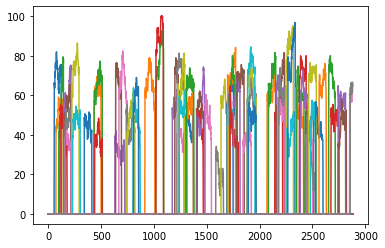

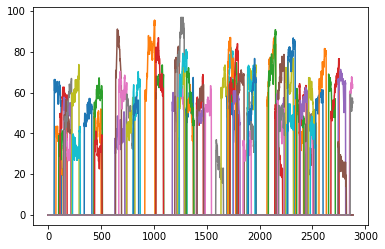

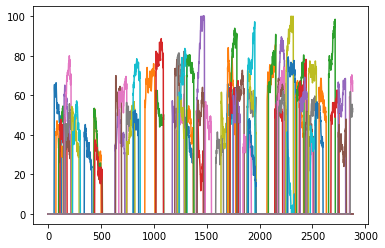

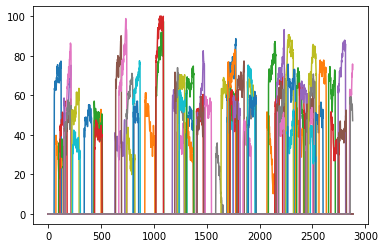

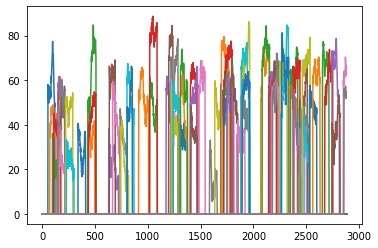

In [14]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 

    #img = plt.imshow(env.render(mode='rgb_array')) # only call this once


    while not done:
        #env.render()

        action = env.action_space.sample()
        
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
    VPP_energies = pd.DataFrame(env.VPP_energies)
    VPP_energies.plot(legend = None)

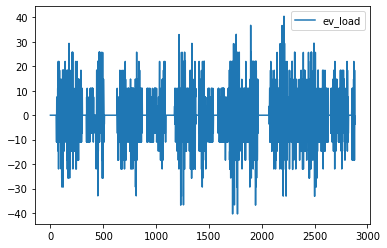

In [15]:
# optimized_total_load_csv = optimized_total_load.to_csv(output_folder + 'optimized_total_load.csv', index = True)
# optimized_total_cost_csv = optimized_total_cost.to_csv(output_folder + 'optimized_total_cost.csv', index = True)

optimized_ev_power_data = pd.read_csv(output_folder + 'optimized_ev_power.csv')
#optimized_ev_power_data['time'] = pd.to_datetime(optimized_ev_power_data['time'])
optimized_ev_power_data = optimized_ev_power_data.iloc[:,2:]
optimized_ev_power_data.plot()

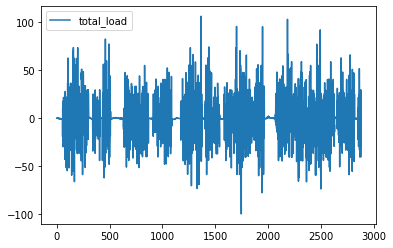

In [16]:
optimized_total_load_data = pd.read_csv(output_folder + 'optimized_total_load.csv')
#optimized_total_load_data['time'] = pd.to_datetime(optimized_total_load_data['time'])
optimized_total_load_data = optimized_total_load_data.iloc[:,2:]
optimized_total_load_data.plot()

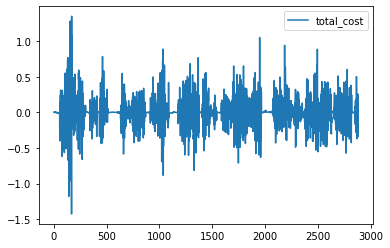

In [17]:
optimized_total_cost_data = pd.read_csv(output_folder + 'optimized_total_cost.csv')
#optimized_total_cost_data['time'] = pd.to_datetime(optimized_total_cost_data['time'])
optimized_total_cost_data = optimized_total_cost_data.iloc[:,2:]
optimized_total_cost_data.plot()

In [18]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, A2C
import time
#Make your storing directories
log_path = 'drive/My Drive/DAI-Labor/Thesis/logs_model/'

#Vectorized environment wrapper
#env = DummyVecEnv([lambda: env])
#PPO??
#model  = PPO('MlpPolicy', Vec_env, verbose=1, tensorboard_log=log_path)
#A2C??
model = A2C("MultiInputPolicy", env, verbose=1, tensorboard_log=log_path)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [19]:
#To view logs in tensorboard
training_log_path = 'drive/My Drive/DAI-Labor/Thesis/logs_model/A2C_tensorboard'
!tensorboard --logdir=(training_log_path)

#Adding a callback to the training stage
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
save_path = 'drive/My Drive/DAI-Labor/Thesis/trained_models/'

stop_callback = StopTrainingOnRewardThreshold(reward_threshold=200, verbose=1)
eval_callback = EvalCallback(env,
                             callback_on_new_best=stop_callback,
                             eval_freq=10000,
                             best_model_save_path=save_path,
                             verbose=1)

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `tensorboard --logdir=(training_log_path)'


In [20]:
%%time
model.learn(total_timesteps=10000)

Logging to drive/My Drive/DAI-Labor/Thesis/logs_model/A2C_11
------------------------------------
| time/                 |          |
|    fps                | 19       |
|    iterations         | 100      |
|    time_elapsed       | 25       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -150     |
|    explained_variance | 0.00358  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 5.65e+03 |
|    value_loss         | 3.19e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 21       |
|    iterations         | 200      |
|    time_elapsed       | 45       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -150     |
|    explained_variance | -0.0731  |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_lo

In [21]:
A2C_Path_file = 'drive/My Drive/DAI-Labor/Thesis/trained_models/A2C_trained'
model.save(A2C_Path_file)

In [22]:
#EVALUATION of the trained model

evaluate_policy(model, env, n_eval_episodes=10, render=False)

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


Total cost: €  -101.72088627920594 , Total energy consumed: KWh  -12067.416932400001
Total cost: €  -156.45270702920592 , Total energy consumed: KWh  -18073.316932399997
Total cost: €  -204.7132445292059 , Total energy consumed: KWh  -23436.316932399997
Total cost: €  -247.32567702920585 , Total energy consumed: KWh  -28190.7169324
Total cost: €  -286.03773852920585 , Total energy consumed: KWh  -32495.1169324
Total cost: €  -316.39115502920583 , Total energy consumed: KWh  -35883.8169324
Total cost: €  -344.2467590292058 , Total energy consumed: KWh  -38914.2169324
Total cost: €  -369.2570925292058 , Total energy consumed: KWh  -41520.7169324
Total cost: €  -388.5273145292058 , Total energy consumed: KWh  -43653.1169324
Total cost: €  -403.6559702792058 , Total energy consumed: KWh  -45381.61693239999


(42250.8, 5429.61270810359)

In [23]:
#del model
#model = A2C.load(A2C_Path, env = env)

Total cost: €  -407.8500100292058 , Total energy consumed: KWh  -45869.1169324
Episode:1 Score:25063
Total cost: €  -417.17926927920576 , Total energy consumed: KWh  -47192.916932399996
Episode:2 Score:24626
Total cost: €  -425.1892445292058 , Total energy consumed: KWh  -48255.0169324
Episode:3 Score:23007
Total cost: €  -431.8845382792058 , Total energy consumed: KWh  -49030.7169324
Episode:4 Score:23661
Total cost: €  -434.77554027920576 , Total energy consumed: KWh  -49491.316932400005
Episode:5 Score:21691


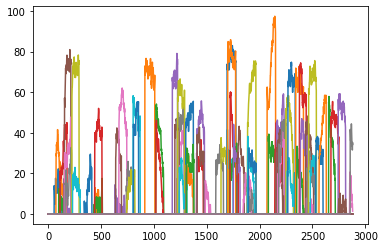

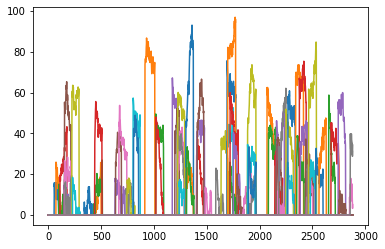

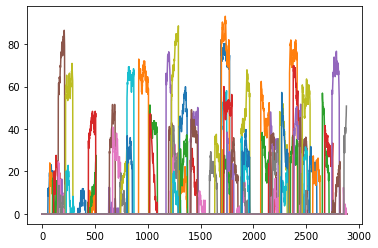

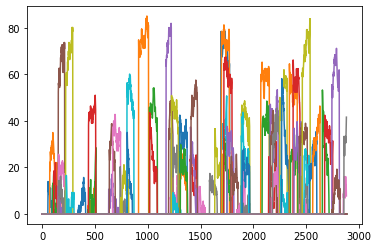

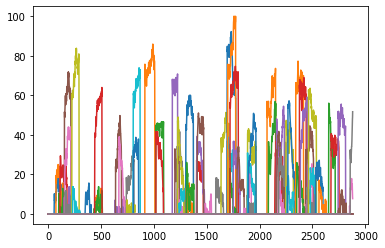

In [24]:
#TEST Model
episodes = 5
for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0 

    #img = plt.imshow(env.render(mode='rgb_array')) # only call this once

    while not done:
        #env.render()
        action, _ = model.predict(obs) #Now using our trained model
        obs, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
    VPP_energies = pd.DataFrame(env.VPP_energies)
    VPP_energies.plot(legend = None)
#env.close()

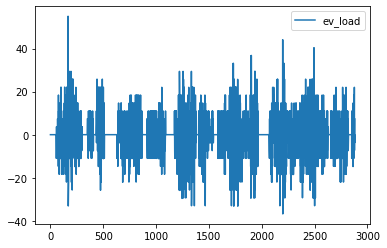

In [25]:
optimized_ev_power_data = pd.read_csv(output_folder + 'optimized_ev_power.csv')
#optimized_ev_power_data['time'] = pd.to_datetime(optimized_ev_power_data['time'])
optimized_ev_power_data = optimized_ev_power_data.iloc[:,2:]
optimized_ev_power_data.plot()

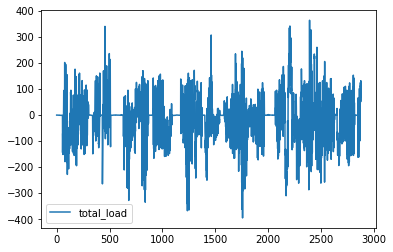

In [26]:
optimized_total_load_data = pd.read_csv(output_folder + 'optimized_total_load.csv')
#optimized_total_load_data['time'] = pd.to_datetime(optimized_total_load_data['time'])
optimized_total_load_data = optimized_total_load_data.iloc[:,2:]
optimized_total_load_data.plot()

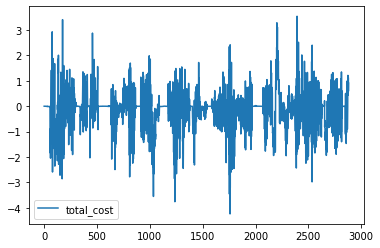

In [27]:
optimized_total_cost_data = pd.read_csv(output_folder + 'optimized_total_cost.csv')
#optimized_total_cost_data['time'] = pd.to_datetime(optimized_total_cost_data['time'])
optimized_total_cost_data = optimized_total_cost_data.iloc[:,2:]
optimized_total_cost_data.plot()

View Logs in Tensorboard

In [28]:
%load_ext tensorboard
%tensorboard — logdir /content/logs

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: invalid choice: '—' (choose from 'serve', 'dev')

In [29]:
!nvidia-smi

Thu Jun 23 12:06:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |   1426MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------